# OOD detection applied to Hallucination Detection

 The goal is to predict if an INPUT prompt  is going to produce an hallucination or not (using OOD detection methods). For now, we don’t look at the output generated by the model, we may consider this in a second time. Retrieve ID samples:  To do this, take a general (easy) QA dataset containing questions along with their true hallucination-free answers. Feed the questions to the model. Let the model generate responses and check if the a given generated response is the same as the real hallucination-free answer. All the correct generated responses will be considered ID. More precisely, the ID dataset will consist of the embeddings of the last token of the last layer of the input (or maybe middle layer) of the correct generated responses.  Test a new sample to see if this is going to be OOD=hallucination: Take another dataset containing questions susceptible to trigger hallucinations along with the true hallucination-free answers (or no answer if the model cannot know the answer by any way and all response that the model might produce will necessarily be hallucinated). Feed a question to the model and let it generate a response. Check by comparing to the hallucination-free answer is that generated response is hallucinated or not. At the same time, apply an OOD detection method on the input question (at the last token last layer) and see if there is a correspondence between a high OOD score and a generated hallucination. 

In [1]:
# import libraries
# -----------------------------------
import torch
import sys
import time 
import os 
import pickle
from functools import partial
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

In [2]:
# Define global variables
# -----------------------------------
SEED = 777 #44
BATCH_SIZE = 16 #32
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
OUTPUT_DIR = "../results/raw/" 
PLOT_DIR   = "../results/figures/" 
LAYER = -1      # (integer) - Layer from witch retrieve the embeddings 
TOKENS = "-1"  # (string) - How to retrieve the embeddings 
K_BEAMS = 1 #3
ACTIVATION_SOURCE = "generation" # can be 'generation', 'PromptGeneration'
 
if TOKENS=="0":
    EXTRACTION_MODE = "first_generated"
elif TOKENS=="-1":
    EXTRACTION_MODE = "last"
elif TOKENS=="Avg":
    EXTRACTION_MODE = "average"
elif TOKENS=="Max":
    EXTRACTION_MODE = "max"

In [3]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [4]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Cuda version: 12.6
Number of available de GPU : 2
GPU 1 : NVIDIA GeForce RTX 4090
GPU 2 : NVIDIA GeForce RTX 4090


In [5]:
# Seed everything
# -----------------------------------
from src.utils.general import seed_all
seed_all(SEED)

## Load model

In [6]:
# Load model
# -----------------------------------
from src.model_loader.llama_loader import load_llama

model, tokenizer = load_llama(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load ID dataset

For the ID general dataset, we are going to use the SQUAD 1.1 dataset: 

***SQuAD 1.1:** Comprises over 100,000 question-answer pairs derived from more than 500 Wikipedia articles. Each question is paired with a specific segment of text (a span) from the corresponding article that serves as the answer.*

In [45]:
# Load ID dataset
# -----------------------------------
from src.data_reader.squad_loader import load_id_fit_dataset

id_fit_dataset = load_id_fit_dataset()
id_fit_dataset = id_fit_dataset.shuffle(SEED) 
id_fit_dataset = id_fit_dataset.slice(idx_start=0, idx_end=10_000)
id_fit_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 10000
})
Mean ground-truth answer length: 3.13, Max length: 30
Mean context + question length: 129.91, Max length: 568


In [15]:
# Visualize one generation with the ID dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_prompt
from src.inference.activation_utils import register_forward_activation_hook, extract_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    sample_idx=3,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=-1,
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
) 

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.021 sec
----- Token extraction with single forward pass: 0.038 sec
----- Generation: 0.175 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.005 sec

=== Prompt ===
[INST] <<SYS>>
Given the following passage and question, answer the question by only giving the answer without a complete sentence.
If it cannot be answered based on the passage, reply 'unanswerable':
<</SYS>>

Passage: The Royal College of Chemistry was established by private subscription in 1845 as there was a growing awareness that practical aspects of the experimental sciences were not well taught and that in the United Kingdom the teaching of chemistry in particular had fallen behind that in Germany. As a result of a movement earlier in the decade, many politicians donated funds to establish the college, including Benjamin Disraeli, William Gladstone and Robert Peel. It was also supported by Prince Albert, who

## Define more global variables

In [8]:
# Compute offsets to select the tokens to give to the model
# -----------------------------------
from src.inference.inference_utils import build_prompt
from src.inference.activation_utils import compute_token_offsets

if False:
    idx = 67
    text = build_prompt(id_fit_dataset[idx]["context"], id_fit_dataset[idx]["question"])
    
    START_OFFSET, END_OFFSET = compute_token_offsets(
        text=text,
        tokenizer=tokenizer,
        start_phrase="Passage:", 
        end_phrase=" [/INST]",
        include_start_phrase=True,
        include_end_phrase=False,
        debug=True,
        )

if True:
    START_OFFSET=0
    END_OFFSET=0

In [9]:
OUTPUT_PROMPT_TITLE = f"_layer{LAYER}_token{TOKENS}_prompt_so{START_OFFSET}_eo{END_OFFSET}"
OUTPUT_GEN_TITLE =  f"_layer{LAYER}_token{TOKENS}_{ACTIVATION_SOURCE}_kbeams{K_BEAMS}_so{START_OFFSET}_eo{END_OFFSET}"

print("OUTPUT_TITLE:", OUTPUT_PROMPT_TITLE)
print("OUTPUT_GEN_TITLE:", OUTPUT_GEN_TITLE)

OUTPUT_TITLE: _layer-1_token-1_prompt_so0_eo0
OUTPUT_GEN_TITLE: _layer-1_token-1_generation_kbeams1_so0_eo0


## Compare responses & create new correct dataset

This section only needs to be **RUN ONCE** to compare the ground-truth answers with the generated responses. We will then retain only those generated responses that match the ground-truth answers, effectively creating a new dataset. At this stage, the layer index and the method of token extraction are not relevant—you can set them to any value you like. Our sole focus here is to filter the responses to match the ground truth.

In [ ]:
# Retrieve ID generated responses and compare them to ground-truth 
# -----------------------------------
from src.inference.inference_utils import run_filter_generated_answers_by_similarity, build_prompt
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

output_path = OUTPUT_DIR + "id_fit_results_answers" # + ".pkl"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, computes semantic similarity scores, 
# and appends the results to a pickle file.
print("\nStart generating ID answers and comparing them to ground-truth...")
t0 = time.time()
run_filter_generated_answers_by_similarity(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_dataset),
    output_path=output_path,
    build_prompt_fn=build_prompt
)
t1 = time.time()
print("...end!")
print_time_elapsed(t0, t1, label="ID answers: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=output_path, delete=True, confirm='user') 

In [22]:
# Load ID responses and only keep correct entries 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import filter_correct_entries

# Load extracted answers 
id_fit_answers = load_pickle_batches(OUTPUT_DIR + "../id_fit_results_answers.pkl")
# Only keep rows where the generated responses are similar to the ground-truth answers
ids_correct_answers = filter_correct_entries(id_fit_answers)["id"]
# Create a new dataset contaning only the correct answers 
id_fit_correct_dataset =  id_fit_dataset.filter_by_column('id', ids_correct_answers)
# Save the new correct dataset for later use
#id_fit_correct_dataset.save("../data/datasets/id_fit_correct_dataset.pkl")

Loaded 10000 samples from: ../results/raw/analyse_answers/../id_fit_results_answers.pkl
Size before filtering incorrect samples: 10000.
Size after filtering: 7998. Filtered 2002 samples.


In [23]:
# Load correct dataset
# -----------------------------------
with open("../data/datasets/id_fit_correct_dataset.pkl", "rb") as f:
    id_fit_correct_dataset = pickle.load(f)

id_fit_correct_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 7998
})
Mean ground-truth answer length: 2.94, Max length: 30
Mean context + question length: 129.50, Max length: 568


## Retrieve ID embeddings from input

This section must be executed for each configuration to extract the appropriate layer index and token embeddings.

In [12]:
# Retrieve ID embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import run_prompt_activation_extraction, build_prompt
from src.inference.activation_utils import register_forward_activation_hook, extract_token_activations
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

output_path = f"{OUTPUT_DIR}id_fit_results{OUTPUT_PROMPT_TITLE}" # + ".pkl"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, extracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving ID embeddings from inputs...")
t2 = time.time()
run_prompt_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_correct_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_correct_dataset),
    save_to_pkl=True,
    output_path=output_path,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=LAYER,  
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="ID embeddings: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=output_path, delete=True, confirm='user') 

100%|██████████| 500/500 [06:48<00:00,  1.22it/s]


...end!
ID embeddings: Time elapsed: 06 min 48 sec

Directory '../results/raw/analyse_answers/id_fit_results_layer-1_token-1_prompt_so0_eo0' deleted.


In [20]:
# Free memory 
del id_fit_dataset 
del id_fit_correct_dataset

## Retrieve ID embeddings from generated answer

In [46]:
# Retrieve ID embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import run_prompt_and_generation_activation_extraction, build_prompt
from src.inference.activation_utils import register_generation_activation_hook, extract_token_activations
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

output_path = f"{OUTPUT_DIR}id_fit_results{OUTPUT_GEN_TITLE}"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, extracts token-level activations for the generated answer,
# and appends the results to a pickle file.
print("\nStart retrieving ID embeddings from generated answers...")
t2 = time.time()
res = run_prompt_and_generation_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_correct_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_correct_dataset),
    save_to_pkl=True, 
    output_path=output_path, 
    build_prompt_fn=build_prompt,
    register_generation_activation_hook_fn=register_generation_activation_hook,
    layer_idx=LAYER,
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
    activation_source=ACTIVATION_SOURCE,
    k_beams=K_BEAMS,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="ID embeddings: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=output_path, delete=True, confirm='user') 


Start retrieving ID embeddings from generated answers...


100%|██████████| 63/63 [01:41<00:00,  1.61s/it]

...end!
ID embeddings: Time elapsed: 01 min 41 sec



In [ ]:
# Free memory 
del id_fit_dataset 
del id_fit_correct_dataset

## Load OOD/Hallucinations test datasets 

To evaluate the Hallucination detection in question answering using OOD detection methods, we will use datasets in the SQuAD style:

***SQuAD 2.0:** SQuAD 2.0 extends the original **SQuAD 1.1** dataset by adding around 50,000 unanswerable questions. These questions are carefully designed to look similar to answerable ones, making it more challenging for models to determine when there isn’t enough information in the context to provide an answer.*

**Test Dataset Composition** \
Our test set will include two types of samples:
- ***Impossible samples***: Questions that cannot be answered based on the provided context (i.e., the answer is not present in the text). These are taken from the training split of SQuAD 2.0, selecting only the unanswerable questions.
- ***Possible samples***: Questions where the answer is explicitly present in the context. These are drawn from the validation split of SQuAD 1.1. This ensures there is no overlap with the in-distribution (ID) data from the SQuAD 1.1 training split.

**Note on Evaluation Scope**\
Currently, our evaluation focuses on whether the model can answer questions using only the information provided in the input context. We do not test the model’s internal knowledge or ability to answer questions without supporting context. However, this setup closely matches the OOD scenario: if the information is not in the text, the model should recognize and indicate this.

**Additional Dataset: TriviaQA**\
To further test generalization, we will also use the TriviaQA dataset. Like SQuAD, TriviaQA provides question-answering prompts with supporting context. The model must either extract the correct answer from the context or correctly identify when the answer is not present.


In [47]:
# Load test datasets
# -----------------------------------
from src.data_reader.squad_loader import load_id_test_dataset, load_od_test_dataset

# Load possible test dataset 
id_test_dataset = load_id_test_dataset()
id_test_dataset = id_test_dataset.shuffle(SEED) 
id_test_dataset = id_test_dataset.slice(idx_start=0, idx_end=1000)
id_test_dataset.print_info()

# Load impossible test dataset 
od_test_dataset = load_od_test_dataset()
od_test_dataset = od_test_dataset.shuffle(SEED) 
od_test_dataset = od_test_dataset.slice(idx_start=0, idx_end=1000)
od_test_dataset.print_info()



===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
Mean ground-truth answer length: 2.90, Max length: 24
Mean context + question length: 129.07, Max length: 494

===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
No valid ground-truth answers to compute length stats.
Mean context + question length: 129.87, Max length: 339


In [48]:
# Visualize one generation with the test impossible dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_prompt
from src.inference.activation_utils import register_forward_activation_hook, extract_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    sample_idx=500,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=-1,
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
) 

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.026 sec
----- Token extraction with single forward pass: 0.897 sec
----- Generation: 0.817 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.247 sec

=== Prompt ===
[INST] <<SYS>>
Given the following passage and question, answer the question by only giving the answer without a complete sentence.
If it cannot be answered based on the passage, reply 'unanswerable':
<</SYS>>

Passage: At its press conference at the 2007 Tokyo Game Show, Sony announced DualShock 3 (trademarked DUALSHOCK 3), a PlayStation 3 controller with the same function and design as Sixaxis, but with vibration capability included. Hands-on accounts describe the controller as being noticeably heavier than the standard Sixaxis controller and capable of vibration forces comparable to DualShock 2. It was released in Japan on November 11, 2007; in North America on April 5, 2008; in Australia on April 24, 2008; in N

## Retrieve test embeddings from input

Test embeddings which may be OOD/Hallucinations.

In [15]:
# Retrieve test embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import run_prompt_activation_extraction, build_prompt
from src.inference.activation_utils import register_forward_activation_hook, extract_token_activations
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

od_output_path = f"{OUTPUT_DIR}od_test_results{OUTPUT_PROMPT_TITLE}" 
id_output_path = f"{OUTPUT_DIR}id_test_results{OUTPUT_PROMPT_TITLE}"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, extracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving test impossible embeddings from inputs...")
t2 = time.time()
run_prompt_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl=True, 
    output_path=od_output_path,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=LAYER,  
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible embeddings: ")

print("\nStart retrieving test possible embeddings from inputs...")
t4 = time.time()
run_prompt_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl=True, 
    output_path=id_output_path,
    build_prompt_fn=build_prompt,
    register_forward_activation_hook_fn=register_forward_activation_hook,
    layer_idx=LAYER,  
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible embeddings: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=od_output_path, delete=True, confirm='user') 
_= merge_batches_and_cleanup(directory=id_output_path, delete=True, confirm='user') 


Start retrieving test impossible embeddings from inputs...


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


...end!
Test impossible embeddings: Time elapsed: 00 min 05 sec


Start retrieving test possible embeddings from inputs...


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]

...end!
Test possible embeddings: Time elapsed: 00 min 05 sec



## Check generated responses from the OOD test dataset

In [49]:
from src.inference.inference_utils import run_filter_generated_answers_by_similarity, build_prompt
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

output_path = OUTPUT_DIR + "od_test_results_answersTEST" # + ".pkl"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, computes semantic similarity scores, 
# and appends the results to a pickle file.
print("\nStart generating test impossible answers and comparing them to ground-truth...")
t0 = time.time()
run_filter_generated_answers_by_similarity(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    output_path=output_path,
    build_prompt_fn=build_prompt
)
t1 = time.time()
print("...end!")
print_time_elapsed(t0, t1, label="Test impossible embeddings: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=output_path, delete=True, confirm='user') 


Start generating test impossible answers and comparing them to ground-truth...


100%|██████████| 63/63 [01:46<00:00,  1.68s/it]


...end!
Test impossible embeddings: Time elapsed: 01 min 46 sec

Directory '../results/raw/ood_test_results_answersTEST' deleted.


In [57]:
# Load test impossible responses and only keep correct entries 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import filter_correct_entries

# Load extracted answers 
od_test_answers = load_pickle_batches(OUTPUT_DIR + "od_test_results_answersTEST.pkl")

print(od_test_answers.keys())
print(od_test_answers['gen_answers'])

Loaded 1000 samples from: ../results/raw/od_test_results_answersTEST.pkl
dict_keys(['id', 'original_indices', 'gen_answers', 'ground_truths', 'is_correct', 'sbert_scores', 'rouge_scores'])
['Vedanta and Yoga.', 'Michigan Central Railroad.', 'Answer: 200 mm', 'Church Building Act of 1818', 'Unanswerable. The passage does not provide information about Americans serving in World War I.', 'Domestication.', 'Tamagotchi.', 'Miami accent', 'Ontology and epistemology.', 'Appeal from the New to the Old Whigs', "Unanswerable. The passage does not provide information on when Dell's enterprise revenue made up a large chunk of its loss.", 'Nintendo Power', 'Monica Olvera de la Cruz', 'Unanswerable. The passage does not provide information about American culture.', 'Answer: Grid system of streets', 'Anglo-Americans combined Marxian and Freudian perspectives.', 'Polyester.', 'Albania', 'Uranium is not a beta emitter.', 'Silver coins.', 'Vaccination', 'Topeka and Pitusa.', 'The Cardinal Camerlengo.', 

In [20]:
# Free memory 
del od_test_dataset 
del id_test_dataset

## Retrieve test embeddings from generated answer

In [16]:
# Retrieve test embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import run_prompt_and_generation_activation_extraction, build_prompt
from src.inference.activation_utils import register_generation_activation_hook, extract_token_activations
from src.utils.general import print_time_elapsed
from src.data_reader.pickle_io import merge_batches_and_cleanup

od_output_path = f"{OUTPUT_DIR}od_test_results{OUTPUT_PROMPT_TITLE}" 
id_output_path = f"{OUTPUT_DIR}id_test_results{OUTPUT_PROMPT_TITLE}"

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, extracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving test impossible embeddings from answers...")
t2 = time.time()
run_prompt_and_generation_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl=True, 
    output_path=f"{OUTPUT_DIR}od_test_results{OUTPUT_GEN_TITLE}.pkl",
    build_prompt_fn=build_prompt,
    register_generation_activation_hook_fn=register_generation_activation_hook,
    layer_idx=LAYER,
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
    activation_source=ACTIVATION_SOURCE,
    k_beams=K_BEAMS,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible embeddings: ")


print("\nStart retrieving test possible embeddings from answers...")
t4 = time.time()
run_prompt_and_generation_activation_extraction(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl=True, 
    output_path=f"{OUTPUT_DIR}id_test_results{OUTPUT_GEN_TITLE}.pkl",
    build_prompt_fn=build_prompt,
    register_generation_activation_hook_fn=register_generation_activation_hook,
    layer_idx=LAYER,
    extract_token_activations_fn=partial(extract_token_activations, mode=EXTRACTION_MODE),
    activation_source=ACTIVATION_SOURCE,
    k_beams=K_BEAMS,
    start_offset=START_OFFSET,
    end_offset=END_OFFSET
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible embeddings: ")

# Merge all batches, save as a single file and delete batch directory
_= merge_batches_and_cleanup(directory=od_output_path, delete=True, confirm='user') 
_= merge_batches_and_cleanup(directory=id_output_path, delete=True, confirm='user') 


Start retrieving test impossible embeddings from answers...


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


...end!
Test impossible embeddings: Time elapsed: 00 min 13 sec


Start retrieving test possible embeddings from answers...


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

...end!
Test possible embeddings: Time elapsed: 00 min 11 sec



In [17]:
# Free memory 
del od_test_dataset 
del id_test_dataset

# Analyse results

In [ ]:
# import libraries
# -----------------------------------
import torch
import sys
import os 
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

## Load extracted embeddings 

In [22]:
SEED = 777 
LAYER = -1     # can be -1 or 16
TOKENS = "Avg"   # can be "0" (first token), "-1" (last token), "Avg" (average token), "Max" (max of tokens)
START_OFFSET=0 # always 0 for now
END_OFFSET=0   # always 0 for now
K_BEAMS = 1    # always 1 for now 
# ACTIVATION_SOURCE: if we want to extract the hidden states from the generated answer 
# only or from the prompt+generated answer.
ACTIVATION_SOURCE = "generation" # can be 'generation' or 'PromptGeneration' 

OUTPUT_DIR = "../results/raw/" 
PLOT_DIR   = "../results/figures/" 
OUTPUT_PROMPT_TITLE = f"_layer{LAYER}_token{TOKENS}_prompt_so{START_OFFSET}_eo{END_OFFSET}"
OUTPUT_GEN_TITLE =  f"_layer{LAYER}_token{TOKENS}_{ACTIVATION_SOURCE}_kbeams{K_BEAMS}_so{START_OFFSET}_eo{END_OFFSET}"

print("OUTPUT_PROMPT_TITLE:", OUTPUT_PROMPT_TITLE)
print("OUTPUT_GEN_TITLE:", OUTPUT_GEN_TITLE)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("PLOT_DIR:", PLOT_DIR)

# ===================================
# /.\ IMPORTANT
# ===================================
# - Select `OUTPUT_TITLE=OUTPUT_GEN_TITLE` to analyze the embeddings of the response 
# (ACTIVATION_SOURCE='generation') or (ACTIVATION_SOURCE='promptGeneration')
# - Select `OUTPUT_TITLE=OUTPUT_PROMPT_TITLE` to analyze the embeddings of the prompt

#OUTPUT_TITLE = OUTPUT_GEN_TITLE
OUTPUT_TITLE = OUTPUT_PROMPT_TITLE

OUTPUT_PROMPT_TITLE: _layer-1_tokenAvg_prompt_so0_eo0
OUTPUT_GEN_TITLE: _layer-1_tokenAvg_generation_kbeams1_so0_eo0
OUTPUT_DIR: ../results/raw/
PLOT_DIR: ../results/figures/


In [8]:
from src.data_reader.pickle_io import get_dir_size
_=get_dir_size(OUTPUT_DIR)

Size of Directory ../results/raw/: 2.77 GB


In [23]:
# Load ID embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches

# Load extracted embeddings 
id_fit_embeddings = load_pickle_batches(f"{OUTPUT_DIR}id_fit_results{OUTPUT_TITLE}.pkl",)
# Convert numpy arrays into torch tensors
id_fit_embeddings = [torch.from_numpy(arr) for arr in id_fit_embeddings['activations']]
# Concatenate all embeddings 
id_fit_embeddings = torch.cat(id_fit_embeddings, dim=0) # shape: [n_samples, hidden_size]


Loaded 7998 samples from: ../results/raw/id_fit_results_layer-1_tokenAvg_prompt_so0_eo0.pkl


In [24]:
# Load test embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches

# Load extracted possible and impossible embeddings 
od_test_embeddings = load_pickle_batches(f"{OUTPUT_DIR}id_test_results{OUTPUT_TITLE}.pkl")
id_test_embeddings = load_pickle_batches(f"{OUTPUT_DIR}od_test_results{OUTPUT_TITLE}.pkl")
# Convert numpy arrays into torch tensors
od_test_embeddings = [torch.from_numpy(arr) for arr in od_test_embeddings['activations']]
id_test_embeddings = [torch.from_numpy(arr) for arr in id_test_embeddings['activations']]
# Concatenate possible and impossible all embeddings 
od_test_embeddings = torch.cat(od_test_embeddings, dim=0) # shape: [n_samples, hidden_size]
id_test_embeddings = torch.cat(id_test_embeddings, dim=0) # shape: [n_samples, hidden_size]

Loaded 1000 samples from: ../results/raw/id_test_results_layer-1_tokenAvg_prompt_so0_eo0.pkl
Loaded 1000 samples from: ../results/raw/od_test_results_layer-1_tokenAvg_prompt_so0_eo0.pkl


In [25]:
# Plot PCA, t-SNE and UMAP of unclassified samples  
# -----------------------------------
from src.analysis.visual_analysis import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 50}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, 
    labels_ood=None,
    pca_config=pca_config
)

# --- t-SNE only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, 
    labels_ood=None,
    tsne_config=tsne_config
)

# --- UMAP only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, 
    labels_ood=None,
    umap_config=umap_config
)

/home/lila.roig/.env/ood_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/lila.roig/.env/ood_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Compute OOD scores

In [12]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [28]:
# ===================================
# Perform DKNN
# ===================================
from src.analysis.dknn import score_tensor,  fit_to_dataset

# Constructs the FAISS index from ID data.
# -----------------------------------
index = fit_to_dataset(id_fit_embeddings)

# Compute DKNN scores on test data
# -----------------------------------
k=5
dknn_scores_id  = score_tensor(index, id_test_embeddings, nearest=k, batch_size=BATCH_SIZE)
dknn_scores_ood = score_tensor(index, od_test_embeddings, nearest=k, batch_size=BATCH_SIZE)

In [16]:
# ===================================
# Perform Cosine Similarity
# ===================================
from src.analysis.cosine import compute_cosine_similarity

# Compute cosine similarity
# -----------------------------------
cossim_scores = compute_cosine_similarity(
    id_fit_embeddings=id_fit_embeddings,
    id_test_embeddings=id_test_embeddings,
    od_test_embeddings=od_test_embeddings,
    center_type = 'mean',
    seed = SEED
)
cossim_scores_id = cossim_scores['cossim_scores_id']
cossim_scores_ood = cossim_scores['cossim_scores_ood']

In [67]:
# ===================================
# Perform Mahalanobis Distance
# ===================================
from src.analysis.mahalanobis import compute_mahalanobis_distance

# Compute cosine similarity
# -----------------------------------
maha_scores = compute_mahalanobis_distance(
    id_fit_embeddings=id_fit_embeddings,
    id_test_embeddings=id_test_embeddings,
    od_test_embeddings=od_test_embeddings,
    center_type = 'mean',
    seed = SEED
)
maha_scores_id = maha_scores['maha_scores_id']
maha_scores_ood = maha_scores['maha_scores_ood']

In [29]:
# Select method to compute OOD scores
# -----------------------------------
# A high DeepKNN score (distance to k-th NN) => OOD data (far from ID neighbors)
# A low DeepKNN score                        => ID data (close to ID neighbors)
# ***********************************
# A high Cosine similarity score => ID data (aligned with ID center)
# A low Cosine similarity score  => OOD data (different direction)
# ***********************************
# A high Mahalanobis score => OOD data (far from ID distribution)
# A low Mahalanobis score  => ID data (close to ID distribution)
# ***********************************
import numpy as np

scores_id  = dknn_scores_id
scores_ood = dknn_scores_ood
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

'''
scores_id  = - cossim_scores_id    # minus sign to match logic: high score => OOD 
scores_ood = - cossim_scores_ood   # minus sign to match logic: high score => OOD 
print("\nMean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))

scores_id  = maha_scores_id
scores_ood = maha_scores_ood
print("\nMean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))
'''

Mean of ID scores: 0.35909486
Mean of OOD scores: 0.4095392


'\nscores_id  = - cossim_scores_id    # minus sign to match logic: high score => OOD \nscores_ood = - cossim_scores_ood   # minus sign to match logic: high score => OOD \nprint("\nMean of ID scores:", np.mean(scores_id))\nprint("Mean of OOD scores:", np.mean(scores_ood))\n\nscores_id  = maha_scores_id\nscores_ood = maha_scores_ood\nprint("\nMean of ID scores:", np.mean(scores_id))\nprint("Mean of OOD scores:", np.mean(scores_ood))\n'

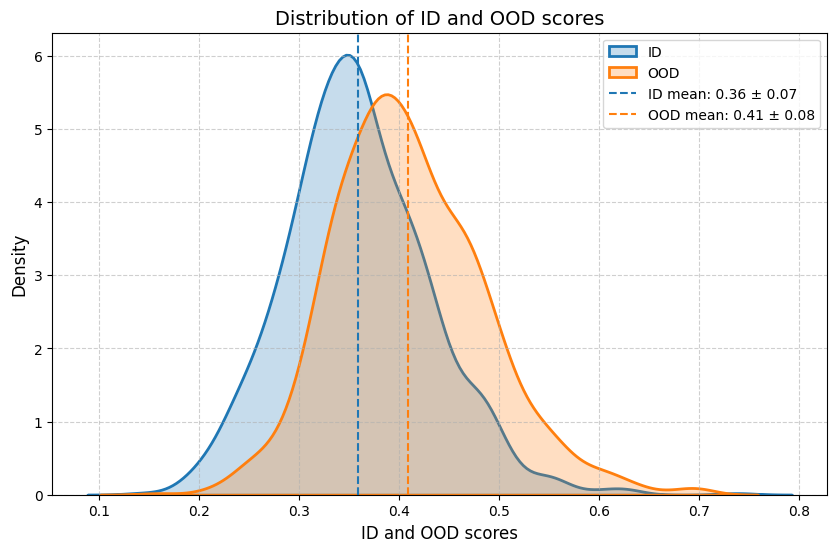

In [30]:
# Plot ID and OOD score distributions 
# -----------------------------------
from src.analysis.visual_analysis import plot_score_distributions
plot_score_distributions(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)


auROC: 0.6893
FPR95: 0.8140
AUC-PR: 0.6684
Optimal Threshold (Youden's J statistic): 0.3755


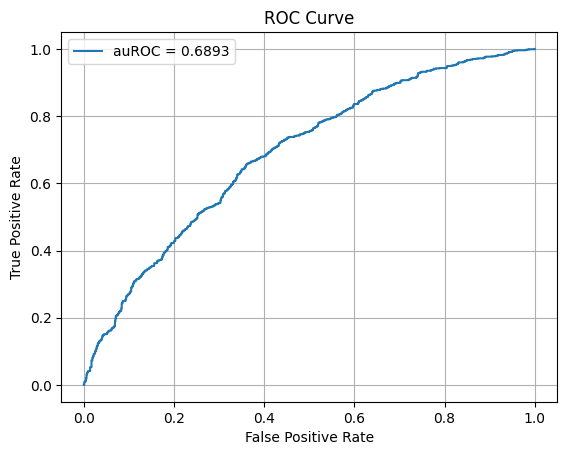

In [31]:
# Compute and plot auroc 
# -----------------------------------
from src.analysis.visual_analysis import compute_auroc
auroc, fpr95, auc_pr, fpr, tpr, thresholds, youden_threshold = compute_auroc(
    scores_id=scores_id, 
    scores_ood=scores_ood, 
    plot=True,
    #save_path= f"{PLOT_DIR}roc{OUTPUT_TITLE}_k{k}.png"
)

:'(

Accuracy: 0.6475
F1 score: 0.6505
Precision: 0.6450
Recall: 0.6560


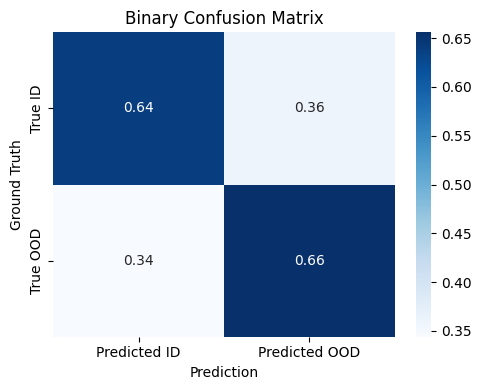

In [32]:
# Generate labels for each test point => 2 possible labels 
# -----------------------------------
"""
Predicted class is assigned as follows:
    - score >  threshold -> predicted OOD (label 1)
    - score <= threshold -> predicted ID (label 0)
"""
# Ground-truth labels: 0 for ID, 1 for OOD
y_true = np.concatenate((
    np.zeros(len(scores_id)),
    np.ones(len(scores_ood))
))
# Predicted labels based on threshold
y_pred = np.concatenate((
    (scores_id > youden_threshold).astype(int),
    (scores_ood > youden_threshold).astype(int)
))

# Compute confusion matrix
# -----------------------------------
from src.analysis.visual_analysis import compute_confusion_matrix_and_metrics
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true,
    y_pred=y_pred,
    plot= True,
    normalize=True,
) 

In [20]:
# Generate labels for each test point => 4 possible labels 
# -----------------------------------
import numpy as np
'''
Class 0: ID well classified  (true ID,  score < threshold)
Class 1: OOD well classified (true OOD, score > threshold)
Class 2: OOD not detected    (true OOD, score < threshold)
Class 3: ID not detected     (true ID,  score > threshold)
'''
# Assumes that :
# Low score => ID, High score => OOD
labels_id = np.where(scores_id   < youden_threshold, 0, 3)   # 0: ID correct, 3: ID not detected
labels_ood = np.where(scores_ood > youden_threshold, 1, 2)   # 1: OOD correct, 2: OOD not detected

In [51]:
# Plot PCA, t-SNE and UMAP of classified samples  
# -----------------------------------
from src.analysis.visual_analysis import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 100}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---

_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=labels_id, 
    labels_ood=labels_ood, 
    pca_config=pca_config
)

'''
# --- t-SNE ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, #labels_id, 
    labels_ood=None, #labels_ood, 
    tsne_config=tsne_config
)

# --- UMAP---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=None, #labels_id, 
    labels_ood=None, #labels_ood, 
    umap_config=umap_config
)

# --- PCA + UMAP---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_embeddings, 
    od_test_embeddings=od_test_embeddings, 
    labels_id=labels_id, 
    labels_ood=labels_ood, 
    pca_config=pca_config_preprocessing,
    umap_config=umap_config
)
'''

'\n# --- t-SNE ---\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_embeddings, \n    od_test_embeddings=od_test_embeddings, \n    labels_id=None, #labels_id, \n    labels_ood=None, #labels_ood, \n    tsne_config=tsne_config\n)\n\n# --- UMAP---\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_embeddings, \n    od_test_embeddings=od_test_embeddings, \n    labels_id=None, #labels_id, \n    labels_ood=None, #labels_ood, \n    umap_config=umap_config\n)\n\n# --- PCA + UMAP---\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_embeddings, \n    od_test_embeddings=od_test_embeddings, \n    labels_id=labels_id, \n    labels_ood=labels_ood, \n    pca_config=pca_config_preprocessing,\n    umap_config=umap_config\n)\n'

## Linear Probing

Accuracy: 0.9050
F1 score: 0.9064
Precision: 0.8932
Recall: 0.9200


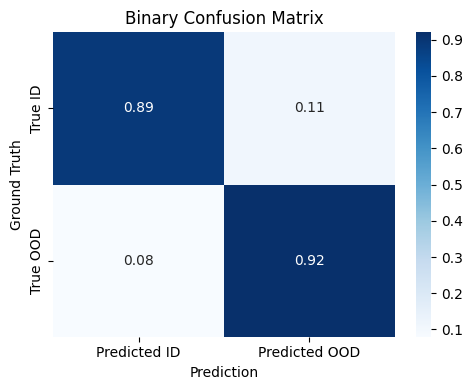

In [26]:
# ===================================
# Perform logistic regression 
# ===================================
from src.analysis.visual_analysis import compute_confusion_matrix_and_metrics
from src.analysis.logistic_regression import train_logistic_regression_on_embeddings

clf, y_true, y_pred = train_logistic_regression_on_embeddings(
    id_test_embeddings, od_test_embeddings, random_state=SEED, test_size=0.1
)
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true,
    y_pred=y_pred,
    plot= True,
    normalize=True,
) 